<a href="https://colab.research.google.com/github/debarati-nath/Detection_of_Wood_Knot/blob/main/UNet_Wood_Knot_Detection_Debarati.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Project on Detection of Wood Knots**

In [136]:
# Import Libraries

import albumentations
import numpy as np
import pathlib
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt

from functools import partial
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.externals._pilutil import bytescale
from skimage.util import crop
from skimage.transform import rescale, rotate
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from typing import List, Callable, Tuple
from torch.utils import data
from tqdm import tqdm, trange

In [137]:
# Create random seed
random_seed = 42

All functions and classes are written for data augmentation and loading dataset from a specific folder

In [138]:
#####################Data augmentation helpers start here#######################
################################################################################

def normalize_data(inp: np.ndarray):
    """
    Normalize the images.
    Squash image input to the value range [0, 1] and no clipping was used.
    
    """

    inp_out = (inp - np.min(inp)) / np.ptp(inp)

    return inp_out

def create_dense_target(tar: np.ndarray):
  """

    Dense target was created.

  """

  classes = np.unique(tar)
  dummy = np.zeros_like(tar)
  
  for idx, value in enumerate(classes):
    
    mask = np.where(tar == value)
    dummy[mask] = idx
    
    return dummy

class Repr():
    """
    Evaluable string representation of an object. This class calls another 
    functions for doing specific performance.
    """

    def __repr__(self): 
      return f'{self.__class__.__name__}: {self.__dict__}'



class FunctionWrapperDouble(Repr):
    """
    A function wrapper that returns a partial for an input-target pair. This 
    class calls another class for calling another function for doing specific 
    performance so that Repr class was not initialized here.

    """

    def __init__(self, function: Callable, input: bool = True, 
                 target: bool = False, *args, **kwargs):
      
        self.function = partial(function, *args, **kwargs)
        self.input = input
        self.target = target

    def __call__(self, inp: np.ndarray, tar: dict):

        if self.input: inp = self.function(inp)
        if self.target: tar = self.function(tar)

        return inp, tar


class Compose():
    """
    Baseclass was created for composing different transforms together.

    """

    def __init__(self, transforms: List[Callable]):
        self.transforms = transforms

    def __repr__(self): 
      return str([transform for transform in self.transforms])


class ComposeDouble(Compose):
    """
    Composes transforms for input-target pairs. This class calls Compose class
    for composing different transforms together.

    """

    def __call__(self, inp: np.ndarray, target: dict):

        for t in self.transforms:
            inp, target = t(inp, target)
        return inp, target


class AlbuSeg2d(Repr):
    """

    Wrapper for albumentations' segmentation-compatible 2D augmentations.
    Wraps an augmentation so it can be used within the provided transform 
    pipeline. This class calls Repr class for doing the albumentations' 
    segmentation-compatible 2D augmentaions

    """

    def __init__(self, albumentation: Callable):
        self.albumentation = albumentation

    def __call__(self, inp: np.ndarray, tar: np.ndarray):

        # Input and target

        out_dict = self.albumentation(image=inp, mask=tar)
        input_out = out_dict['image']
        target_out = out_dict['mask']

        return input_out, target_out



In [139]:
########################DataLoader helpers start here###########################
################################################################################

# Function for loading inputs and targets from a specific directory

def get_filenames_of_path(path: pathlib.Path, ext: str = "*"):
    """

    Returns a list of files in a directory/path. pathlib was used here.

    """

    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames

# Class is created for loading and transforming dataset.

class Data_Augmentation(data.Dataset):
    """

    Dataset were imported.
    Transformation was done.
    Torch from numpy were done.

    """

    def __init__(self, inputs: list, targets: list, transform=None):

        self.inputs = inputs
        self.targets = targets
        self.transform = transform
        self.inputs_dtype = torch.float32
        # Use torch.int64 as long for targets
        self.targets_dtype = torch.long

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index: int):

        # Select the sample
        input_id = self.inputs[index]
        target_id = self.targets[index]

        # Load input and target
        x, y = imread(str(input_id)), rgb2gray(imread(str(target_id)))

        # Preprocessing if the transformation function is given. 
        # Otherwise returns the input-target pair.
        if self.transform is not None:
            x, y = self.transform(x, y)

        # Convert torch from numpy
        x, y = torch.from_numpy(x).type(self.inputs_dtype),\
                               torch.from_numpy(y).type(self.targets_dtype)

        return x, y

*U-net model was created here. Firstly, different function was created for convolution layer separately and call them in U-Net class*

In [140]:
###################################U-Net class##################################
################################################################################

class UNet(nn.Module):
  """
  Two convolution blocks were created with batchnormalization and relu function
  called blockconv. bottleneck was the last down conv and then ConvTrans2d was 
  used for upsampling. Maxpooling layer was also used between two blockconv 
  layers.

  """
  def __init__(self, in_channels=3, out_channels=2, init_features=32):
    super(UNet, self).__init__()
    
    features = init_features
    self.encoder_1 = UNet.blockconv(in_channels, features, name="enc_1")
    self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2) # MaxPool layer
    self.encoder_2 = UNet.blockconv(features, features * 2, name="enc_2")
    self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.encoder_3 = UNet.blockconv(features * 2, features * 4, name="enc_3")
    self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.encoder_4 = UNet.blockconv(features * 4, features * 8, name="enc_4")
    self.pool_4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.bottleneck = UNet.blockconv(features * 8, 
                                     features * 16, 
                                     name="bottleneck")
    # Transpose layer
    self.upconv_4 = nn.ConvTranspose2d(features * 16, 
                                      features * 8, 
                                      kernel_size=2, 
                                      stride=2)
    self.decoder_4 = UNet.blockconv((features * 8) * 2, 
                                   features * 8, 
                                  name="dec_4")
    self.upconv_3 = nn.ConvTranspose2d(features * 8, 
                                      features * 4, 
                                      kernel_size=2, 
                                      stride=2)
    self.decoder_3 = UNet.blockconv((features * 4) * 2, features * 4, 
                                   name="dec_3")
    self.upconv_2 = nn.ConvTranspose2d(features * 4, features * 2, 
                                      kernel_size=2, stride=2)
    self.decoder_2 = UNet.blockconv((features * 2) * 2, features * 2, 
                                    name="dec_2")
    self.upconv_1 = nn.ConvTranspose2d(features * 2, features, 
                                      kernel_size=2, stride=2)
    self.decoder_1 = UNet.blockconv(features * 2, features, name="dec_1")

    self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, 
                          kernel_size=1)

  def forward(self, x):
    enc_1 = self.encoder_1(x)
    enc_2 = self.encoder_2(self.pool_1(enc_1))
    enc_3 = self.encoder_3(self.pool_2(enc_2))
    enc_4 = self.encoder_4(self.pool_3(enc_3))

    bottleneck = self.bottleneck(self.pool_4(enc_4))

    dec_4 = self.upconv_4(bottleneck)
    dec_4 = torch.cat((dec_4, enc_4), dim=1)
    dec_4 = self.decoder_4(dec_4)
    dec_3 = self.upconv_3(dec_4)
    dec_3 = torch.cat((dec_3, enc_3), dim=1)
    dec_3 = self.decoder_3(dec_3)
    dec_2 = self.upconv_2(dec_3)
    dec_2 = torch.cat((dec_2, enc_2), dim=1)
    dec_2 = self.decoder_2(dec_2)
    dec_1 = self.upconv_1(dec_2)
    dec_1 = torch.cat((dec_1, enc_1), dim=1)
    dec_1 = self.decoder_1(dec_1)
    return torch.sigmoid(self.conv(dec_1))

  # Function is for the convolution layers
  def blockconv(in_channels, features, name):
    return nn.Sequential(nn.Conv2d(in_channels=in_channels,
                                   out_channels=features,
                                   kernel_size=3, padding=1,
                                   bias=False),
                        nn.BatchNorm2d(num_features=features), # Normalization
                        nn.ReLU(inplace=True), # Activation
                        nn.Conv2d(in_channels=features,
                                  out_channels=features,
                                  kernel_size=3,
                                 padding=1,
                                 bias=False),
                        nn.BatchNorm2d(num_features=features), # Normalization
                        nn.ReLU(inplace=True)) # Activation


          

Class with functions for training and validation

In [141]:
###########################Trainer class for training###########################
################################################################################

class Trainer:
  """
  3 functions were written for training and validating.
  """
  def __init__(
        self,
        model: torch.nn.Module,
        criterion: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        training_DataLoader: torch.utils.data.Dataset,
        validation_DataLoader: torch.utils.data.Dataset = None,
        epochs: int = 100,
        epoch: int = 0):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.epochs = epochs
        self.epoch = epoch

        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []

  def run_trainer(self):

        progressbar = trange(self.epochs, desc="Progress")
        for i in progressbar:

            self.epoch += 1  # Epoch counter

            self._train()   # Train block

            if self.validation_DataLoader is not None:
                self._validate()   # Validation block

        return self.training_loss, self.validation_loss, self.learning_rate

  def _train(self):


        self.model.train()  # Train mode
        train_losses = []  # Accumulate the losses here
        batch_iter = tqdm(
            enumerate(self.training_DataLoader),
            "Training",
            total=len(self.training_DataLoader),
            leave=False,
        )

        for i, (x, y) in batch_iter:
            input, target = x, y
           
            self.optimizer.zero_grad()  # zerograd the parameters
            out = self.model(input)  # One forward pass
            loss = self.criterion(out, target)  # Calculate loss
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # One backward pass
            self.optimizer.step()  # Update the parameters

            batch_iter.set_description(
                f"Training: (loss {loss_value:.4f})"
            )  # Update progressbar

        self.training_loss.append(np.mean(train_losses))
        self.learning_rate.append(self.optimizer.param_groups[0]["lr"])

        batch_iter.close()

  def _validate(self):


        self.model.eval()  # Evaluation mode
        valid_losses = []  # Accumulate the losses here
        batch_iter = tqdm(
            enumerate(self.validation_DataLoader),
            "Validation",
            total=len(self.validation_DataLoader),
            leave=False,
        )

        for i, (x, y) in batch_iter:
            input, target = x, y

            with torch.no_grad():
                out = self.model(input)
                loss = self.criterion(out, target)
                loss_value = loss.item()
                valid_losses.append(loss_value)

                batch_iter.set_description(f"Validation: (loss \
                                                     {loss_value:.4f})")

        self.validation_loss.append(np.mean(valid_losses))

        batch_iter.close()

Functions for testing

In [142]:
########################Testing helpers start here##############################
################################################################################

# Function for updating
def update_info(idx, length, epoch_loss, mode):

  if length >= 250:
    update_size = int(length/250)


  if idx != 0:

    finish_rate = idx/length * 100
    print ("\r {} progress: {:.2f}% ...... loss: {:.4f}".
    format(mode, finish_rate, epoch_loss/idx), end="", flush=True)

# Testing Function
def model_testing(model, loss_fn, dataloader, verbose=True):
  Y_pred = []
  correct = 0
  total = 0
  epoch_loss = 0.0
  test_size = 0
  with torch.no_grad():
    for i, (feature, target) in enumerate(dataloader):
      feature = feature
      target = target
      outputs = model(feature) 
      test_size += target.size(0)
      loss = criterion(outputs, target)
      epoch_loss += loss.item()
      idx = i
      length = len(dataloader)
      if verbose:
        update_info(idx, length, epoch_loss, 'testing') 
  print('\n\n Loss of the network on the {} test images: {}'.format(test_size, 
                                                    epoch_loss/len(dataloader)))
  return epoch_loss / len(dataloader)

***Training***

Loading the inputs and targets for training

In [143]:
# Create Root Directory for importing Dataset

root = pathlib.Path.cwd() / "drive/MyDrive/for_input"

# Input and target files
inputs = get_filenames_of_path(root / "input")
targets = get_filenames_of_path(root / "target")


*Transformation for inputs and targets*

In [144]:
# Call functions and classes for transforming the datasets
transforms = ComposeDouble([  
     FunctionWrapperDouble(resize,
                          input=True,
                          target=False,
                          output_shape=(256, 256, 3)),
    FunctionWrapperDouble(resize,
                          input=False,
                          target=True,
                          output_shape=(256, 256),
                          order=0,
                          anti_aliasing=False,
                          preserve_range=True),
    AlbuSeg2d(albumentations.HorizontalFlip(p=0.5)),
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input = True, 
                          target = False, source = -1, 
                          destination=0),
    FunctionWrapperDouble(normalize_data)
])

In [145]:
# Split dataset into training set and validation set with 80:20
train_size = 0.8  

inputs_train, inputs_valid = train_test_split(
    inputs, random_state=random_seed, train_size=train_size, shuffle=True)

targets_train, targets_valid = train_test_split(
    targets, random_state=random_seed, train_size=train_size, shuffle=True)


# Training dataset
dataset_train = Data_Augmentation(
    inputs=inputs_train, targets=targets_train, transform=transforms)

# Validation dataset
dataset_valid = Data_Augmentation(
    inputs=inputs_valid, targets=targets_valid, transform=transforms)

# Training dataloader
dataloader_training = DataLoader(dataset=dataset_train, 
                                 batch_size=2, 
                                 shuffle=True)

# Validation dataloader
dataloader_validation = DataLoader(dataset=dataset_valid, 
                                   batch_size=2, 
                                   shuffle=True)

*Printing shapes of input and target*

In [146]:
# Input = x and target =y
x, y = next(iter(dataloader_training))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.


x = shape: torch.Size([2, 3, 256, 256]); type: torch.float32
x = min: 0.0; max: 1.0
y = shape: torch.Size([2, 256, 256]); class: tensor([0]); type: torch.int64


In [147]:
# Call the U-Net model for training
# In_channels = 3, Out-channels = 2, Initialize_filters = 32
model = UNet(3, 2, 32)

# Function for initializing weight
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight) # Initialize weight
        m.bias.data.fill_(0.01)                # Initialize bias

# Apply initial weights
model.apply(init_weights)

UNet(
  (encoder_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool_2): MaxPool2d(kernel_s

In [148]:
####################################Training####################################
################################################################################

# Initialize criterion
criterion = torch.nn.CrossEntropyLoss()

# Initialize optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Call the trainer class
trainer = Trainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    training_DataLoader=dataloader_training,
    validation_DataLoader=dataloader_validation,
    epochs=20,
    epoch=0
)

# Start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

Training:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.

Training: (loss 0.7329): 100%|██████████| 6/6 [00:29<00:00,  4.47s/it]
                                                                      
Validation:   0%|          | 0/2 [00:00<?, ?it/s]
Validation: (loss                                                      0.7075):   0%|          | 0/2 [00:03<?, ?it/s]
Validation: (loss                                                      0.7075):  50%|█████     | 1/2 [00:03<00:03,  3.17s/it]
Validation: (loss                                                      0.7061):  50%|█████     | 1/2 [00:04<00:03,  3.17s/it]
Validation: (loss                                                      0.7061): 100%|██████████| 2/2 [00:04<00:00

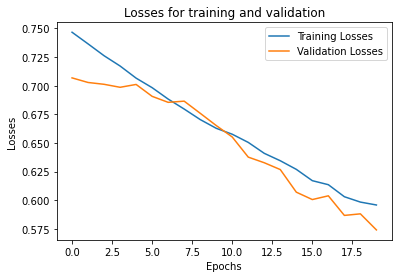

In [149]:
plt.plot(training_losses, label = "Training Losses")
plt.plot(validation_losses, label = "Validation Losses")

# X-axis
plt.xlabel('Epochs')

# Y-axis
plt.ylabel('Losses')

# Title
plt.title('Losses for training and validation')
 
# Legend
plt.legend()
 
# Plot
plt.show()


***Testing***

In [150]:
#####################################Testing####################################
################################################################################

# Create root directory for importing test dataset
root1 = pathlib.Path.cwd() / "drive/MyDrive/for_testing"

# For testing dataset
test_inputs = get_filenames_of_path(root1 / "input")
test_targets = get_filenames_of_path(root1 / "target")

*Transformation for testing*

In [151]:
transform_testing = ComposeDouble([  
     FunctionWrapperDouble(resize,
                          input=True,
                          target=False,
                          output_shape=(256, 256, 3)),
    FunctionWrapperDouble(resize,
                          input=False,
                          target=True,
                          output_shape=(256, 256),
                          order=0,
                          anti_aliasing=False,
                          preserve_range=True),
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input = True, 
                          target = False, source = -1, 
                          destination=0),
])

In [152]:
# Testing dataset
dataset_test = Data_Augmentation(
    inputs=test_inputs, targets=test_targets, transform=transform_testing)

# Testing dataloader
dataloader_testing = DataLoader(dataset=dataset_test, 
                                 shuffle=True)

In [153]:
# Input_test = x and target_test =y
x, y = next(iter(dataloader_testing))

# Print the shape of test dataset
print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.


x = shape: torch.Size([1, 3, 256, 256]); type: torch.float32
x = min: 0.0313725508749485; max: 0.9843137264251709
y = shape: torch.Size([1, 256, 256]); class: tensor([0]); type: torch.int64


In [154]:
# Rub testing
if __name__ == '__main__':
 Y_pred1 = model_testing(model, criterion, dataloader_testing, True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.


 testing progress: 85.71% ...... loss: 0.6543

 Loss of the network on the 7 test images: 0.5607946770531791
